# Plot snapshots of Kirk (al122024)

In [38]:
# General
import os
import glob

# Display
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.gridspec import GridSpec
import matplotlib.colors as mcolors
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.patches as mpatches

# Data treatment
import xarray as xr
import numpy as np
# from scipy.interpolate import griddata
from scipy.optimize import curve_fit
import pandas as pd 
from tqdm.notebook import tqdm
import ephem

# Default parameters
fontsize = 16
mpl.rcParams.update({'font.size': fontsize})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [67]:
### Paths & Params
PRMS = {
    'ibt_vars2keep':    ['usa_lon', 'usa_lat', 'usa_pres', 'usa_wind', 'usa_r34', 'usa_r50', 'usa_r64', 'usa_rmw', 'storm_speed', 'storm_dir', 'name', 'sid'],
    'ibt_info2keep':    ['sid', 'basin', 'name', 'usa_atcf_id', 'usa_agency', 'iso_time', 'usa_status'],
}

PTHS = {
    'sar_pth': '/home/arthur/data/tropical_cyclones/SAR/parametric_dataset/dsg.nc',
    'sar_dir': '/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/',
    'sav_dir': '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_UC_DIAGNOSTIC/06_PLOT_SNAPSHOTS/',
    'ibt_pth': '/home/arthur/data/tropical_cyclones/ibtracs/24032025/IBTrACS.ALL.v04r01.nc',
}

### Open data
# SAR
dsg        = xr.open_dataset(PTHS['sar_pth'])

# IBTrACS
ds_ibt_all = xr.open_dataset(PTHS['ibt_pth'])
# Select variables
ds_ibt                        = ds_ibt_all[PRMS['ibt_vars2keep']]
ds_ibt[PRMS['ibt_info2keep']] = ds_ibt_all[PRMS['ibt_info2keep']].astype(str, copy=False) # Convert byte arrays to strings
# Select dates
start_date                    = np.datetime64('2009-01-01')
fsi                           = np.nanargmin(np.abs(ds_ibt['time'][:, 0] - start_date)) # First storm index
ds_ibt                        = ds_ibt.isel(storm=slice(fsi, None))
# Convert to m/s and m units
for speed in ['usa_wind', 'storm_speed']:
    ds_ibt[speed]  *= 0.5144
for radius in ['usa_r34', 'usa_r50', 'usa_r64', 'usa_rmw']:
    ds_ibt[radius] *= 1852
# Add mean radii
# Non-zero average!!
ds_ibt['mean_r34'] = xr.where(ds_ibt.usa_r34 != 0, ds_ibt.usa_r34, np.nan).mean(dim='quadrant', skipna=True)
ds_ibt['mean_r50'] = xr.where(ds_ibt.usa_r50 != 0, ds_ibt.usa_r50, np.nan).mean(dim='quadrant', skipna=True)
ds_ibt['mean_r64'] = xr.where(ds_ibt.usa_r64 != 0, ds_ibt.usa_r64, np.nan).mean(dim='quadrant', skipna=True)
# Intensification and growing rates in IBTrACS
ds_ibt['vmx_smth']       = ds_ibt.usa_wind.rolling(date_time=4, center=True, min_periods=2).mean()
ds_ibt['r34_smth']       = ds_ibt.mean_r34.rolling(date_time=4, center=True, min_periods=2).mean()
ds_ibt['vmx_dot_smth']   = ds_ibt.vmx_smth.differentiate(coord='date_time') / 3 # m/s/hr
ds_ibt['r34_dot_smth']   = ds_ibt.r34_smth.differentiate(coord='date_time') / 3 # km/hr
# ==> Add LMI values
new                      = ds_ibt.fillna(-9999)
idx_lmi                  = new.vmx_smth.argmax(dim='date_time')
# LMI
ds_ibt['lmi']            = ds_ibt.usa_wind[:, idx_lmi]
ds_ibt['t_lmi']          = ds_ibt.time[:, idx_lmi]
# time since LMI
dt                       = (ds_ibt.time - ds_ibt.t_lmi)
dt_scds                  = dt.dt.days * 24 * 3600 + dt.dt.seconds # Nb of days + Nb of seconds (>= 0 and less than 1 day) for each element
ds_ibt['t_since_lmi']    = dt_scds # in seconds

In [3]:
### Choose ID
atcf_id = 'al122024'

In [4]:
# GROUP BY BASIN
dsg['basin_idx'] = dsg.vmx.copy(deep=True) * np.nan
# basin_keys       = np.unique(dsg.basin)
basin_keys       = np.array(['al', 'cp', 'ep', 'wp', 'io', 'sh']) # Same order like Chavas et al 2016
for t in tqdm(range(len(dsg.time))):
    dsg['basin_idx'][t] = np.where(basin_keys == dsg.isel(time=t).basin.item())[0][0] + 1
basin_keys_combined = np.concatenate((['all'], basin_keys))

  0%|          | 0/1666 [00:00<?, ?it/s]

In [5]:
# FILTERS
cond = (
    (dsg.center_quality_flag < 2) & 
    (dsg.percent_outside < 50) & 
    (dsg.percent_rmx_inside == 1) &
    (abs(dsg.lat) < 30) & 
    (dsg.rmx < 100000) & 
    (dsg.vmx > 20)
)
d    = dsg.where(cond, drop=True)
print(len(d.time))

640


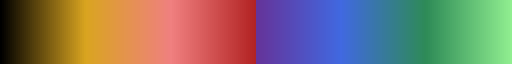

In [6]:
### Colormap

# Définition des limites de la plage totale
vmin = -72
vmax = 72

# Segment 1: -72 à -48
color_neg_72 = 'black'
color_neg_48 = 'goldenrod' 

# Segment 2: -48 à -24
color_neg_24 = 'lightcoral' 

# Segment 3: -24 à 0
color_zero_neg_side = 'firebrick' 

# Segment 4: 0 à 24
color_zero_pos_side = 'rebeccapurple' 

# Segment 5: 24 à 48
color_pos_24 = 'royalblue'

# Segment 6: 48 à 72
color_pos_48 = 'seagreen'
color_pos_72 = 'lightgreen' 

# Fonction utilitaire pour normaliser une valeur
def normalize_value(val, vmin, vmax):
    return (val - vmin) / (vmax - vmin)

colors_and_positions = [
    # Segment 1: -72 à -48 (de noir à rouge foncé)
    (normalize_value(vmin, vmin, vmax), color_neg_72),
    (normalize_value(-48, vmin, vmax), color_neg_48),

    # Segment 2: -48 à -24 (de rouge foncé à orange)
    # Note: color_neg_48 est répété pour assurer la continuité
    (normalize_value(-48, vmin, vmax), color_neg_48), # Point de départ du segment 2
    (normalize_value(-24, vmin, vmax), color_neg_24),

    # Segment 3: -24 à 0 (d'orange à gris clair)
    (normalize_value(-24, vmin, vmax), color_neg_24), # Point de départ du segment 3
    (normalize_value(0, vmin, vmax), color_zero_neg_side),

    # Segment 4: 0 à 24 (de gris clair à bleu clair)
    (normalize_value(0, vmin, vmax), color_zero_pos_side), # Point de départ du segment 4
    (normalize_value(24, vmin, vmax), color_pos_24),

    # Segment 5: 24 à 48 (de bleu clair à vert foncé)
    (normalize_value(24, vmin, vmax), color_pos_24), # Point de départ du segment 5
    (normalize_value(48, vmin, vmax), color_pos_48),

    # Segment 6: 48 à 72 (de vert foncé à violet à jaune vif)
    (normalize_value(48, vmin, vmax), color_pos_48), # Point de départ du segment 6
    (normalize_value(vmax, vmin, vmax), color_pos_72),
]

cmap_points = [
    (normalize_value(vmin, vmin, vmax), color_neg_72),
    (normalize_value(-48, vmin, vmax), color_neg_48),
    (normalize_value(-24, vmin, vmax), color_neg_24),
    (normalize_value(0, vmin, vmax), color_zero_neg_side), # Couleur à 0 pour les négatifs
    (normalize_value(0, vmin, vmax), color_zero_pos_side), # Couleur à 0 pour les positifs (pour une transition nette si désirée)
    (normalize_value(24, vmin, vmax), color_pos_24),
    (normalize_value(48, vmin, vmax), color_pos_48),
    (normalize_value(vmax, vmin, vmax), color_pos_72)
]

cmap = mcolors.LinearSegmentedColormap.from_list("custom_multi_segment_cmap", cmap_points)

# Pour la normalisation, TwoSlopeNorm est toujours appropriée si 0 est votre centre de pivot
norm = mcolors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

cmap

In [7]:
### Select case
# SAR
ds  = d.where(d.id == atcf_id, drop=True)
# BTK
dsi = ds_ibt.where(ds_ibt.usa_atcf_id == atcf_id.upper(), drop=True).isel(storm=0)
dsi = dsi.where(((dsi.t_since_lmi / 3600) >= -72) & ((dsi.t_since_lmi / 3600) <= 72), drop=True)

In [8]:
# A23 and other parameters
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                             # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter assuming it's constant 
    return fcor

def M(f, r, V):
    return r * V + 0.5 * f * (r ** 2)

def Rmax_from_M(fcor, Mmax, Vmax):
    return (Vmax / fcor) * (np.sqrt(1 + (2 * fcor * Mmax) / (Vmax ** 2)) - 1)

def correct_vmx_ibt(vmx_ibt):
    return 0.6967 * vmx_ibt + 6.1992

def holland_profile(r, lat, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor   = abs(coriolis(lat))
    rho    = 1.15
    r      = r.astype(float) + 0.001           # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt( ((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

# Bounds for fitting
BDS_HOL = {
    'B':      [0.01, 3.],
    'Vmin':   [0, 50],
    'Rmax':   [5 * 1000, 500 * 1000],
    'Vmax':   [10, 100],   
}

# Basics
dsi['vmx_reg'] = correct_vmx_ibt(dsi['usa_wind'])
dsi['fcr']     = coriolis(dsi['usa_lat'])

# Rmax A23
# Compute the momentum ratios
Mm_M34 = 0.531 * np.exp(
    -0.00214 * (dsi['vmx_reg'] - 17.5)
    -0.00314 * (dsi['vmx_reg'] - 17.5) * 0.5 * dsi['fcr'] * dsi['mean_r34']
)
Mm_M50 = 0.626 * np.exp(
     0.00282 * (dsi['vmx_reg'] - 25.7)
    -0.00724 * (dsi['vmx_reg'] - 25.7) * 0.5 * dsi['fcr'] * dsi['mean_r50']
)
Mm_M64 = 0.612 * np.exp(
     0.00946 * (dsi['vmx_reg'] - 32.9)
    -0.01183 * (dsi['vmx_reg'] - 32.9) * 0.5 * dsi['fcr'] * dsi['mean_r64']
)
# Compute Mmax
Mm_with_r34 = Mm_M34 * M(dsi['fcr'], dsi['mean_r34'], 17.5)
Mm_with_r50 = Mm_M50 * M(dsi['fcr'], dsi['mean_r50'], 25.7)
Mm_with_r64 = Mm_M64 * M(dsi['fcr'], dsi['mean_r64'], 32.9)
# Compute Rmax_CK22A23
Rm_with_r34 = Rmax_from_M(dsi['fcr'], Mm_with_r34, dsi['vmx_reg'])
Rm_with_r50 = Rmax_from_M(dsi['fcr'], Mm_with_r50, dsi['vmx_reg'])
Rm_with_r64 = Rmax_from_M(dsi['fcr'], Mm_with_r64, dsi['vmx_reg'])
# Assign to your dataset
dsi['new_rmx'] = Rm_with_r34.copy(deep=True)
dsi['new_rmx'][Rm_with_r50.notnull()] = Rm_with_r50.copy(deep=True)[Rm_with_r50.notnull()]
dsi['new_rmx'][Rm_with_r64.notnull()] = Rm_with_r64.copy(deep=True)[Rm_with_r64.notnull()]

# Others
dsi['rsb']     = dsi['usa_wind'] / (abs(dsi['fcr']) * dsi['usa_rmw'])
dsi['r0']      = np.sqrt(2 * dsi['rsb']) * dsi['usa_rmw']
dsi['new_rsb'] = dsi['vmx_reg'] / (abs(dsi['fcr']) * dsi['new_rmx'])
dsi['new_r0']  = np.sqrt(2 * dsi['new_rsb']) * dsi['new_rmx']

In [10]:
def pol2cart(r, th):
    x = r * np.cos(th)
    y = r * np.sin(th)
    return x, y

In [11]:
### COLORMAP SAR
import sys
import os

# Ajoutez le dossier parent 'my_modules' au chemin de recherche
# Le chemin '..' permet de remonter d'un niveau par rapport à l'emplacement du notebook
module_path = os.path.abspath(os.path.join('../..', 'tools/'))
print(f"Chemin du module à ajouter : {module_path}")

if module_path not in sys.path:
    sys.path.append(module_path)
    
# Importez la classe CMAP depuis votre script
from cmap_sar import CMAP

# Maintenant, vous pouvez appeler les méthodes de la classe CMAP
cmap_cyclobs, vmin, vmax = CMAP.cyclobs_wind10m(return_vminvmax=True, unit="m/s")
print(f"Colormap créée : {cmap_cyclobs.name}")
print(f"Valeurs min/max : {vmin:.2f} m/s et {vmax:.2f} m/s")
ticks_cyclobs = [5.14444, 17.4911, 25.7222, 32.9244, 42.6989, 49.1433, 58.1, 69.959]

Chemin du module à ajouter : /home/arthur/scripts/tools
Colormap créée : cyclobs_wind10m
Valeurs min/max : 0.00 m/s et 69.96 m/s


/tmp/ipykernel_24465/3176282860.py:4: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap       = mpl.cm.get_cmap('PuOr') # Spectral
/tmp/ipykernel_24465/3176282860.py:23: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolormesh.
  im           = ax.pcolormesh(x_sar / 1000, y_sar / 1000, dss['wind_speed'], cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)
/tmp/ipykernel_24465/3176282860.py:68: UserWarning: The input coordinates to pcolormesh are interpreted as cell centers, but are not monotonically increasing or decreasing. This may lead to incorrectly calculated cell edges, in which case, please supply explicit cell edges to pcolo

/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/rcm1-sclnd-owi-ca-20241001t205843-20241001t210000-00003-______sw_al122024_cyclone_polar.nc
/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/rcm1-sclnc-owi-ca-20241003t211627-20241003t211742-00003-______sw_al122024_cyclone_polar.nc
/home/arthur/data/tropical_cyclones/SAR/S1_RS2_RCM/sar_files/rcm1-sclnd-owi-ca-20241005t213448-20241005t213606-00003-______sw_al122024_cyclone_polar.nc


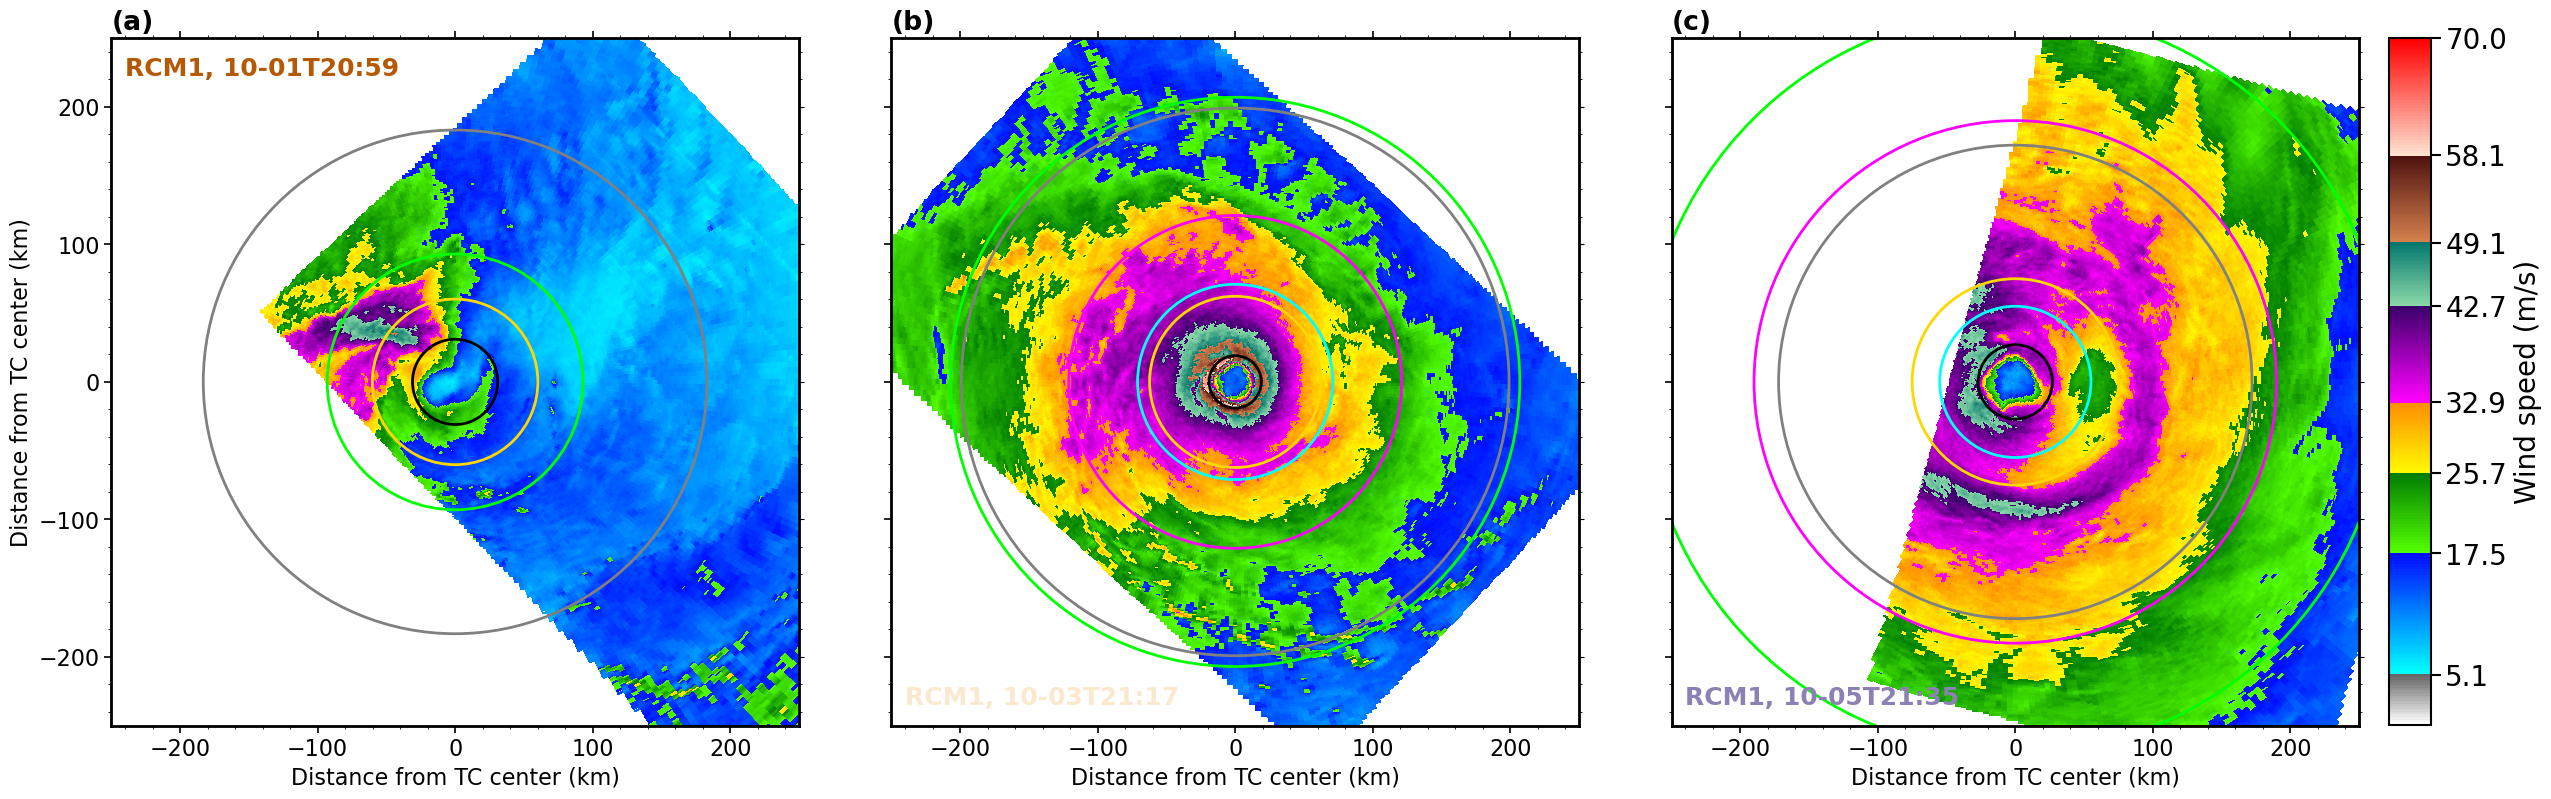

In [68]:
fig        = plt.figure(figsize=(30, 30))
gs         = GridSpec(3, 3, hspace=0.18, wspace=0.02)

cmap       = mpl.cm.get_cmap('PuOr') # Spectral

normalizer = Normalize(0, 80)
ax_lims2D  = 250

##########
# CASE 1 #
##########
k   = 0
p1  = PTHS['sar_dir'] + ds.isel(time=k).file_tcva.item()
dss = xr.open_dataset(p1).isel(time=0)

### SAR
ax = fig.add_subplot(gs[:1, 0])
ax.set_title('(a)', weight='bold', loc='left')
ax.text(0.02, 0.945, 'RCM1, {}'.format(np.datetime_as_string(dss.time, unit='m')[5:]), transform = ax.transAxes, weight='bold', fontsize=18, c=cmap(norm(ds.isel(time=k).t_since_lmi_ibt / 3600)))

# Wind map
y_sar, x_sar = pol2cart(dss['rad'], np.deg2rad(dss['theta']))
im           = ax.pcolormesh(x_sar / 1000, y_sar / 1000, dss['wind_speed'], cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)
# Wind radii
ax.add_patch(mpatches.Circle((0, 0), float(ds.isel(time=k).rmx) / 1000, edgecolor='k',    facecolor='none', linewidth=2))
ax.add_patch(mpatches.Circle((0, 0), float(ds.isel(time=k).r34) / 1000, edgecolor='lime', facecolor='none', linewidth=2))
ax.add_patch(mpatches.Circle((0, 0), float(ds.isel(time=k).r50) / 1000, edgecolor='magenta', facecolor='none', linewidth=2))
ax.add_patch(mpatches.Circle((0, 0), float(ds.isel(time=k).r64) / 1000, edgecolor='cyan', facecolor='none', linewidth=2))
ax.add_patch(mpatches.Circle((0, 0), float(ds.isel(time=k).r0)  / 1000, edgecolor='gray', facecolor='none', linewidth=2))
ax.add_patch(mpatches.Circle((0, 0), float(ds.isel(time=k).rps) / 1000, edgecolor='gold', facecolor='none', linewidth=2))

ax.set_xlim(-ax_lims2D, ax_lims2D);ax.set_ylim(-ax_lims2D, ax_lims2D)
ax.set_xlabel('Distance from TC center (km)')
ax.set_ylabel('Distance from TC center (km)')
ax.set_box_aspect(1)
ax.tick_params(axis='both', length=5, width=1.2)
ax.minorticks_on()

ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

ax2 = ax.twinx().twiny() 
ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.minorticks_on()
ax2.tick_params(axis='both', length=5, width=1.2)
ax2.set_box_aspect(1)
ax2.set_yticklabels([])
ax2.set_xticklabels([])

dss.close()

##########
# CASE 2 #
##########
k   = 4
p2  = PTHS['sar_dir'] + ds.isel(time=k).file_tcva.item()
dss = xr.open_dataset(p2).isel(time=0)

### SAR
ax = fig.add_subplot(gs[:1, 1])
ax.set_title('(b)', weight='bold', loc='left')
ax.text(0.02, 0.03, 'RCM1, {}'.format(np.datetime_as_string(dss.time, unit='m')[5:]), transform = ax.transAxes, weight='bold', fontsize=18, c=cmap(norm(ds.isel(time=k).t_since_lmi_ibt / 3600)))

# Wind map
y_sar, x_sar = pol2cart(dss['rad'], np.deg2rad(dss['theta']))
im           = ax.pcolormesh(x_sar / 1000, y_sar / 1000, dss['wind_speed'], cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)
# Wind radii
ax.add_patch(mpatches.Circle((0, 0), float(ds.isel(time=k).rmx) / 1000, edgecolor='k',    facecolor='none', linewidth=2))
ax.add_patch(mpatches.Circle((0, 0), float(ds.isel(time=k).r34) / 1000, edgecolor='lime', facecolor='none', linewidth=2))
ax.add_patch(mpatches.Circle((0, 0), float(ds.isel(time=k).r50) / 1000, edgecolor='magenta', facecolor='none', linewidth=2))
ax.add_patch(mpatches.Circle((0, 0), float(ds.isel(time=k).r64) / 1000, edgecolor='cyan', facecolor='none', linewidth=2))
ax.add_patch(mpatches.Circle((0, 0), float(ds.isel(time=k).r0)  / 1000, edgecolor='gray', facecolor='none', linewidth=2))
ax.add_patch(mpatches.Circle((0, 0), float(ds.isel(time=k).rps) / 1000, edgecolor='gold', facecolor='none', linewidth=2))

ax.yaxis.set_ticklabels([])
ax.set_xlim(-ax_lims2D, ax_lims2D);ax.set_ylim(-ax_lims2D, ax_lims2D)
ax.set_xlabel('Distance from TC center (km)')
ax.set_box_aspect(1)
ax.minorticks_on()
ax.tick_params(axis='both', length=5, width=1.2)

ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

ax2 = ax.twinx().twiny() 
ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.minorticks_on()
ax2.tick_params(axis='both', length=5, width=1.2)
ax2.set_box_aspect(1)
ax2.set_yticklabels([])
ax2.set_xticklabels([])

dss.close()

##########
# CASE 3 #
##########
k   = 8
p3  = PTHS['sar_dir'] + ds.isel(time=k).file_tcva.item()
dss = xr.open_dataset(p3).isel(time=0)

### SAR
ax = fig.add_subplot(gs[:1, 2])
ax.set_title('(c)', weight='bold', loc='left')
ax.text(0.02, 0.03, 'RCM1, {}'.format(np.datetime_as_string(dss.time, unit='m')[5:]), transform = ax.transAxes, weight='bold', fontsize=18, c=cmap(norm(ds.isel(time=k).t_since_lmi_ibt / 3600)))

# Wind map
y_sar, x_sar = pol2cart(dss['rad'], np.deg2rad(dss['theta']))
im           = ax.pcolormesh(x_sar / 1000, y_sar / 1000, dss['wind_speed'], cmap=cmap_cyclobs, vmin=vmin, vmax=vmax)
# Wind radii
ax.add_patch(mpatches.Circle((0, 0), float(ds.isel(time=k).rmx) / 1000, edgecolor='k',    facecolor='none', linewidth=2))
ax.add_patch(mpatches.Circle((0, 0), float(ds.isel(time=k).r34) / 1000, edgecolor='lime', facecolor='none', linewidth=2))
ax.add_patch(mpatches.Circle((0, 0), float(ds.isel(time=k).r50) / 1000, edgecolor='magenta', facecolor='none', linewidth=2))
ax.add_patch(mpatches.Circle((0, 0), float(ds.isel(time=k).r64) / 1000, edgecolor='cyan', facecolor='none', linewidth=2))
ax.add_patch(mpatches.Circle((0, 0), float(ds.isel(time=k).r0)  / 1000, edgecolor='gray', facecolor='none', linewidth=2))
ax.add_patch(mpatches.Circle((0, 0), float(ds.isel(time=k).rps) / 1000, edgecolor='gold', facecolor='none', linewidth=2))

ax.yaxis.set_ticklabels([])
ax.set_xlim(-ax_lims2D, ax_lims2D);ax.set_ylim(-ax_lims2D, ax_lims2D)
ax.set_xlabel('Distance from TC center (km)')
ax.set_box_aspect(1)
ax.minorticks_on()
ax.tick_params(axis='both', length=5, width=1.2)

ax.spines['left'].set_linewidth(2)
ax.spines['right'].set_linewidth(2)
ax.spines['bottom'].set_linewidth(2)
ax.spines['top'].set_linewidth(2)

ax2 = ax.twinx().twiny() 
ax2.set_xlim(-ax_lims2D, ax_lims2D);ax2.set_ylim(-ax_lims2D, ax_lims2D)
ax2.minorticks_on()
ax2.tick_params(axis='both', length=5, width=1.2)
ax2.set_box_aspect(1)
ax2.set_yticklabels([])
ax2.set_xticklabels([])

# Colorbar
cb_ax = fig.add_axes([0.897, 0.651, 0.014, 0.229])
cbar  = fig.colorbar(im, cax=cb_ax, ticks=ticks_cyclobs)
cbar.set_label('Wind speed (m/s)', rotation=90, fontsize=20)
cbar.ax.get_yaxis().labelpad=5
cbar.set_ticklabels([round(tick, 1) for tick in ticks_cyclobs])
cbar.ax.tick_params(width=1.5, length=7, **{'labelsize': 20})
cbar.outline.set_linewidth(1.5)

dss.close()

print(p1)
print(p2)
print(p3)

# Save
plt.savefig(PTHS['sav_dir'] + 'snapshots.png', bbox_inches='tight')